In [23]:
# ==============================
# 1️⃣ Environment & Libraries
# ==============================
import os
# Fix KMeans memory leak warning on Windows with MKL
os.environ["OMP_NUM_THREADS"] = "4"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set(style="whitegrid")  # nice Seaborn style



In [5]:
df.columns


Index(['id', 'age', 'gender', 'income', 'spending_score', 'membership_years',
       'purchase_frequency', 'preferred_category', 'last_purchase_amount'],
      dtype='object')

In [10]:
# ==============================
# 2️⃣ Load Dataset & Explore
# ==============================
df = pd.read_csv("customer_segmentation_data.csv")  # your actual CSV file
df.columns = df.columns.str.strip().str.replace(' ', '_')  # clean column names

# Quick overview
print(df.head())
print(df.info())
print(df.isnull().sum())



   id  age  gender  income  spending_score  membership_years  \
0   1   38  Female   99342              90                 3   
1   2   21  Female   78852              60                 2   
2   3   60  Female  126573              30                 2   
3   4   40   Other   47099              74                 9   
4   5   65  Female  140621              21                 3   

   purchase_frequency preferred_category  last_purchase_amount  
0                  24          Groceries                113.53  
1                  42             Sports                 41.93  
2                  28           Clothing                424.36  
3                   5      Home & Garden                991.93  
4                  25        Electronics                347.08  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id           

In [11]:
# ==============================
# 3️⃣ Descriptive Statistics
# ==============================
print(df.describe())

# Optional: summarize per customer
customer_summary = df.groupby('id').agg({
    'income':'mean',
    'spending_score':'mean',
    'purchase_frequency':'sum',
    'last_purchase_amount':'sum',
    'membership_years':'mean'
}).reset_index()
customer_summary.head()


                id          age         income  spending_score  \
count  1000.000000  1000.000000    1000.000000     1000.000000   
mean    500.500000    43.783000   88500.800000       50.685000   
std     288.819436    15.042213   34230.771122       28.955175   
min       1.000000    18.000000   30004.000000        1.000000   
25%     250.750000    30.000000   57911.750000       26.000000   
50%     500.500000    45.000000   87845.500000       50.000000   
75%     750.250000    57.000000  116110.250000       76.000000   
max    1000.000000    69.000000  149973.000000      100.000000   

       membership_years  purchase_frequency  last_purchase_amount  
count        1000.00000         1000.000000           1000.000000  
mean            5.46900           26.596000            492.348670  
std             2.85573           14.243654            295.744253  
min             1.00000            1.000000             10.400000  
25%             3.00000           15.000000            218.762500

,id,income,spending_score,purchase_frequency,last_purchase_amount,membership_years
0,1,99342.0,90.0,24,113.53,3.0
1,2,78852.0,60.0,42,41.93,2.0
2,3,126573.0,30.0,28,424.36,2.0
3,4,47099.0,74.0,5,991.93,9.0
4,5,140621.0,21.0,25,347.08,3.0


In [14]:
# ==============================
# 4️⃣ Feature Selection & Scaling
# ==============================
features = ['income','spending_score','purchase_frequency','last_purchase_amount','membership_years']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_summary[features])


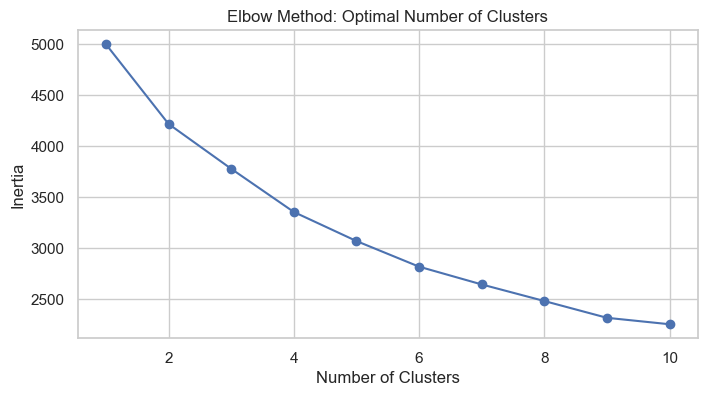

In [24]:
# ==============================
# 5️⃣ Elbow Method
# ==============================


# Suppress KMeans memory leak warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

inertia = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,4))
plt.plot(range(1,11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method: Optimal Number of Clusters')
plt.show()



In [21]:
# ==============================
# 6️⃣ Fit KMeans
# ==============================
n_clusters = 3  # choose based on Elbow plot
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
customer_summary['Segment'] = kmeans.fit_predict(X_scaled)

customer_summary.head()


,id,income,spending_score,purchase_frequency,last_purchase_amount,membership_years,Segment
0,1,99342.0,90.0,24,113.53,3.0,1
1,2,78852.0,60.0,42,41.93,2.0,1
2,3,126573.0,30.0,28,424.36,2.0,2
3,4,47099.0,74.0,5,991.93,9.0,0
4,5,140621.0,21.0,25,347.08,3.0,1


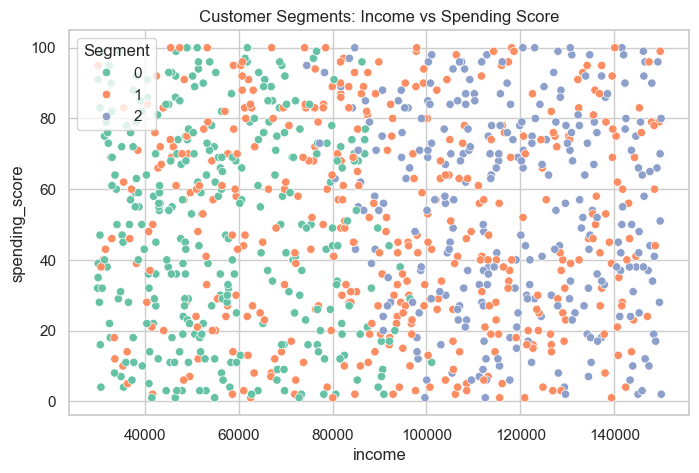

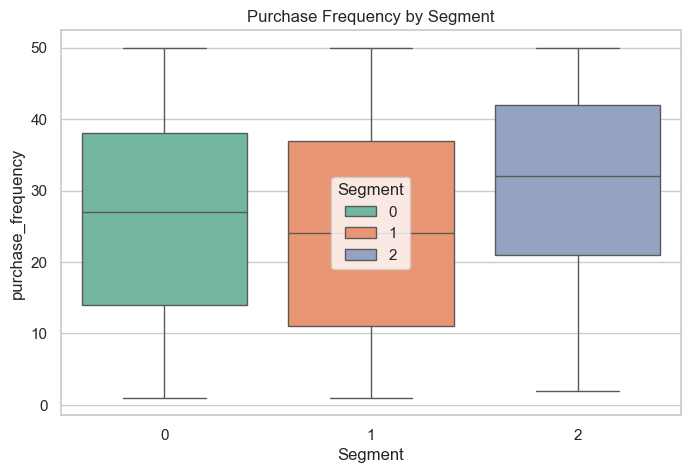

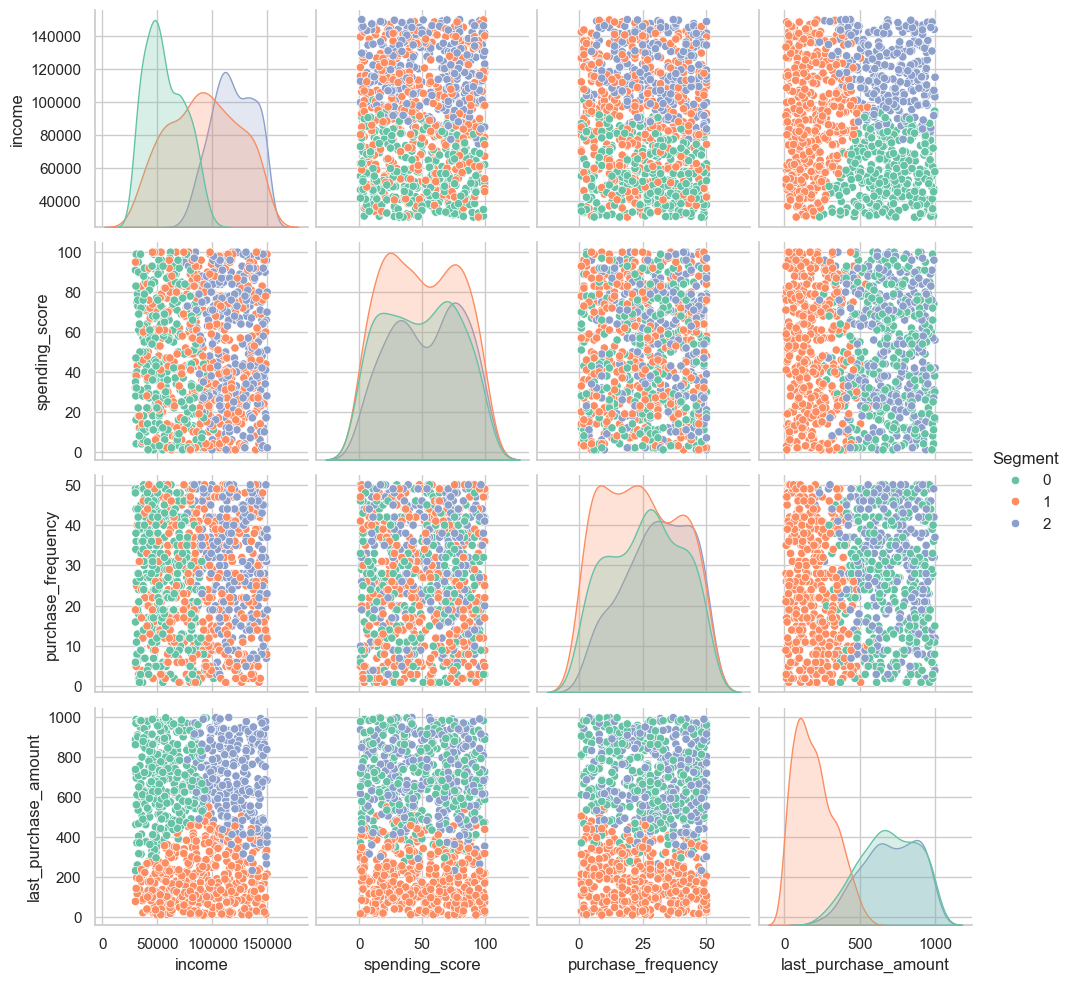

In [26]:
# ==============================
# 7️⃣ Visualizations
# ==============================

# Scatter plot: Income vs Spending Score
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=customer_summary,
    x='income', 
    y='spending_score', 
    hue='Segment',
    palette=sns.color_palette('Set2', n_colors=n_clusters),
    legend='full'
)
plt.title('Customer Segments: Income vs Spending Score')
plt.show()

# Boxplot: Purchase Frequency by Segment (Seaborn future-proof)
plt.figure(figsize=(8,5))
sns.boxplot(
    data=customer_summary,
    x='Segment',
    y='purchase_frequency',
    hue='Segment',  # future-proof
    dodge=False,
    palette=sns.color_palette('Set2', n_colors=n_clusters)
)
plt.title('Purchase Frequency by Segment')
plt.show()

# Optional: Pairplot for all features
sns.pairplot(
    customer_summary,
    vars=['income','spending_score','purchase_frequency','last_purchase_amount'],
    hue='Segment',
    palette=sns.color_palette('Set2', n_colors=n_clusters),
    diag_kind='kde'
)
plt.show()


In [27]:
# ==============================
# 8️⃣ Segment Insights
# ==============================
for seg in range(n_clusters):
    print(f"\nSegment {seg} statistics:")
    display(customer_summary[customer_summary['Segment']==seg][features].describe())



Segment 0 statistics:


,income,spending_score,purchase_frequency,last_purchase_amount,membership_years
count,313.000000,313.000000,313.000000,313.000000,313.000000
mean,56727.549521,48.811502,26.003195,689.089137,5.440895
std,17397.892565,29.091251,14.102304,188.641763,2.858387
min,30004.000000,1.000000,1.000000,223.390000,1.000000
25%,42779.000000,22.000000,14.000000,553.350000,3.000000
50%,53805.000000,50.000000,27.000000,686.830000,5.000000
75%,69864.000000,73.000000,38.000000,846.760000,8.000000
max,101105.000000,100.000000,50.000000,998.090000,10.000000



Segment 1 statistics:


,income,spending_score,purchase_frequency,last_purchase_amount,membership_years
count,407.000000,407.000000,407.000000,407.000000,407.000000
mean,92014.515971,49.759214,24.326781,196.541572,5.378378
std,31305.234621,29.071358,14.637789,128.491395,2.747022
min,30074.000000,1.000000,1.000000,10.400000,1.000000
25%,65937.000000,25.000000,11.000000,95.125000,3.000000
50%,92601.000000,48.000000,24.000000,178.210000,5.000000
75%,116251.000000,75.000000,37.000000,278.180000,8.000000
max,149744.000000,100.000000,50.000000,552.210000,10.000000



Segment 2 statistics:


,income,spending_score,purchase_frequency,last_purchase_amount,membership_years
count,280.000000,280.000000,280.000000,280.000000,280.000000
mean,118911.317857,54.125000,30.557143,702.397679,5.632143
std,18769.864235,28.437735,12.984563,184.421356,3.007226
min,74519.000000,1.000000,2.000000,204.270000,1.000000
25%,105022.750000,29.750000,21.000000,559.730000,3.000000
50%,118621.000000,55.500000,32.000000,706.005000,5.500000
75%,134513.250000,78.000000,42.000000,862.887500,8.250000
max,149973.000000,100.000000,50.000000,999.740000,10.000000
